In [2]:
import time
import datetime
import pickle
import random
import json

import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import transformers

from torch.utils.data import random_split
from collections import defaultdict, Counter
from transformers import BertForMaskedLM, BertTokenizer
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler
from transformers import get_linear_schedule_with_warmup
import statsmodels.stats.proportion

from operator import mul
from functools import reduce


device = 'cuda:0'
softmax = torch.nn.Softmax(dim=-1)
torch.manual_seed(0)
np.random.seed(0)

MODEL_NAME = 'bert-base-multilingual-uncased'

tokenizer = BertTokenizer.from_pretrained(MODEL_NAME)
model = BertForMaskedLM.from_pretrained(MODEL_NAME)
device = torch.device('cuda:0')
model.to(device)
reverse_vocab = {y:x for x, y in tokenizer.vocab.items()}

Some weights of the model checkpoint at bert-base-multilingual-uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [3]:
# let's check the number of tokens in our keywords
keywords = ['ничего', 'никого']
keywords2tokens = dict()

for keyword in keywords:
    tokens = tokenizer.tokenize(keyword)
    keywords2tokens[keyword] = tokens
    print(len(tokens), tokens)


1 ['ничего']
2 ['ни', '##кого']


In [4]:
# parse, mask, tokenize

subj_dict = dict()
verb_dict = dict()

def mask_sent(sent, kword):
    return ['[CLS]',] + tokenizer.tokenize( 
        sent.replace(kword, '[MASK] '*len(keywords2tokens[kword])).replace('  ',' ') 
    ) + ['[SEP]',]

tokenized_array = []
metadata_array = []

for idx, line in enumerate(open('ru_test_sentences_ni.tsv', encoding='utf-8')):
    chunks = line.strip().split()
    tchunks = line.strip().split('\t')

    if chunks[-1]=='thing':
        kwords = ('ничего','ничего','ничего','ничего')
    else:
        kwords = ('никого','никого','никого','никого')

    subj_id = int(chunks[-3])
    subject = chunks[1]
    subj_dict[subj_id] = subject
    verb_id = int(chunks[-2])
    verb1 = chunks[2]
    verb2 = chunks[8]
    verb_dict[verb_id] = (verb1, verb2)
    
    for tidx, (cl,kword) in enumerate( zip( ('aff', 'neg', 'many', 'few'), kwords ) ):
        mt_sent = mask_sent(tchunks[tidx], kword)
        tokenized_array.append( mt_sent )
        metadata_array.append( 
            (
                (cl, subj_id, verb_id, kword, chunks[-1]),
                (tchunks[tidx], mt_sent)
            )
        )


In [6]:
metadata_array[:40]

[(('aff', 1, 21, 'ничего', 'thing'),
  ('люди ничего делали.',
   ['[CLS]', 'люди', '[MASK]', 'дела', '##ли', '.', '[SEP]'])),
 (('neg', 1, 21, 'ничего', 'thing'),
  ('люди ничего не делали.',
   ['[CLS]', 'люди', '[MASK]', 'не', 'дела', '##ли', '.', '[SEP]'])),
 (('many', 1, 21, 'ничего', 'thing'),
  ('многие люди ничего делали.',
   ['[CLS]', 'многие', 'люди', '[MASK]', 'дела', '##ли', '.', '[SEP]'])),
 (('few', 1, 21, 'ничего', 'thing'),
  ('немногие люди ничего делали.',
   ['[CLS]',
    'нем',
    '##ног',
    '##ие',
    'люди',
    '[MASK]',
    'дела',
    '##ли',
    '.',
    '[SEP]'])),
 (('aff', 1, 18, 'ничего', 'thing'),
  ('люди ничего сделали.',
   ['[CLS]', 'люди', '[MASK]', 'сделал', '##и', '.', '[SEP]'])),
 (('neg', 1, 18, 'ничего', 'thing'),
  ('люди ничего не сделали.',
   ['[CLS]', 'люди', '[MASK]', 'не', 'сделал', '##и', '.', '[SEP]'])),
 (('many', 1, 18, 'ничего', 'thing'),
  ('многие люди ничего сделали.',
   ['[CLS]', 'многие', 'люди', '[MASK]', 'сделал', '##и',

In [7]:
def assess_batch(batch, metas):
    batch_input_ids = []
    batch_segment_ids = []
    
    mask_positions = []
    mask_lens = []

    max_len = max(map(len,batch))
    
    for s in batch:
        mask_positions.append( s.index('[MASK]') )
        mask_lens.append( s.count('[MASK]') )
        
        input_ids = tokenizer.convert_tokens_to_ids(s + ["[PAD]",]*(max_len-len(s)))
        batch_input_ids.append( input_ids )
        batch_segment_ids.append( [0] * len(input_ids) )

    input_ids = torch.tensor(batch_input_ids, dtype=torch.long).to(device)
    segment_ids = torch.tensor(batch_segment_ids, dtype=torch.long).to(device)
    logits = model(input_ids, token_type_ids=segment_ids)[0]
    probs = softmax(logits)
    
    return [
        reduce(mul, [pr[pos+t_pos][tokenizer.vocab[tok]].cpu().detach().numpy() \
            for t_pos, tok in enumerate(keywords2tokens[meta[0][3]]) ], 1. ) \
                for pr, pos, meta in zip(probs, mask_positions, metas)
    ]
        
assess_batch(tokenized_array[128*4:130*4], metadata_array[126*4:130*4])

[0.0040571722202003,
 0.11882107704877853,
 0.007178084459155798,
 0.0200650654733181,
 9.675215879322005e-08,
 3.3684867175971694e-11,
 1.1845675830736905e-08,
 2.0086326376185732e-08]

In [8]:
# assess all the sentences

BATCH_SIZE = 64

scores = []
for idx in range(0, len(tokenized_array), BATCH_SIZE):
    scores.extend( assess_batch(tokenized_array[idx:idx+BATCH_SIZE], metadata_array[idx:idx+BATCH_SIZE]) )

In [9]:
len(scores)

40000

In [16]:
from collections import defaultdict

# reshape scores
stats = defaultdict(lambda:defaultdict(lambda:defaultdict(float)))

for score, meta in zip(scores, metadata_array):
    if meta[0][0]=='aff':
        handle = (meta[0][4], 'aff>neg')
        k_idx = 0
    if meta[0][0]=='neg':
        handle = (meta[0][4], 'aff>neg')
        k_idx = 1
    if meta[0][0]=='many':
        handle = (meta[0][4], 'many>few')
        k_idx = 0
    if meta[0][0]=='few':
        handle = (meta[0][4], 'many>few')
        k_idx = 1
    stats[handle][(meta[0][1], meta[0][2])][k_idx] = score
    handle = ('both', handle[1])
    stats[handle][(meta[0][1], meta[0][2])][k_idx] += score


In [18]:
for handle in sorted(stats):
    print(handle, 
          f'  {np.count_nonzero(list(map(lambda x:x[0]>x[1], stats[handle].values())))/len(stats[handle].values()):0.3%}')

('body', 'aff>neg')   0.000%
('body', 'many>few')   5.738%
('both', 'aff>neg')   0.116%
('both', 'many>few')   20.660%
('thing', 'aff>neg')   0.132%
('thing', 'many>few')   22.330%


(array([2.000e+00, 0.000e+00, 0.000e+00, 4.000e+00, 3.000e+00, 1.900e+01,
        8.800e+01, 1.346e+03, 6.128e+03, 5.000e+00]),
 array([-0.0904513 , -0.07949817, -0.06854503, -0.0575919 , -0.04663876,
        -0.03568563, -0.02473249, -0.01377936, -0.00282622,  0.00812691,
         0.01908005]),
 <BarContainer object of 10 artists>)

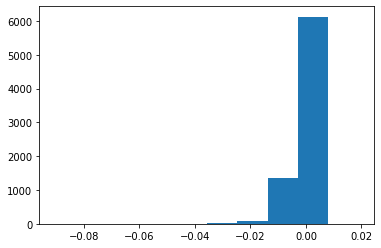

In [12]:
plt.hist(list(map(lambda x:x[0]-x[1],stats[('thing', 'many>few')].values())))

(array([1.000e+00, 8.000e+00, 2.800e+01, 6.800e+01, 1.440e+02, 2.560e+02,
        4.630e+02, 8.420e+02, 1.974e+03, 3.811e+03]),
 array([-7.11420099e-01, -6.40211421e-01, -5.69002742e-01, -4.97794064e-01,
        -4.26585386e-01, -3.55376708e-01, -2.84168030e-01, -2.12959352e-01,
        -1.41750674e-01, -7.05419954e-02,  6.66682783e-04]),
 <BarContainer object of 10 artists>)

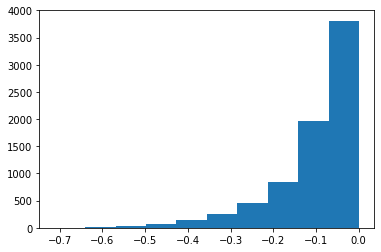

In [13]:
plt.hist(list(map(lambda x:x[0]-x[1],stats[('thing', 'aff>neg')].values())))